# (APERTAR O BOTÃO ACIMA PARA VER O CÓDIGO)

# Relatório Landmarks - Nicholas Richers

In [1]:
#bibliotecas utilizadas
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load libraries and set plot parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 12
import warnings
warnings.filterwarnings('ignore')

# Importação dos Dados:

Utilizando o mesmo dataset já preparado no relatório market basket:
* Haviam 18 filmes com Id duplicado, que foram removidos
* A alteração dos filmes do Id duplicado gerou 522 notas duplicadas (i.e mesmo usuario dando nota pro mesmo filme) (261 foram removidas)

In [3]:
#carrega os dados
from setup_database import setup_BD, setup_results, get_genre, fill_na

#carregando os datasets de ratings
original_ratings_100k = pd.read_csv('./ml-100k/u.data', header=None, delimiter="\t" )
original_ratings_1M = pd.read_csv('./ml-1m/ratings.dat', header=None, delimiter=":" )


#carregando os datasets de filmes
original_movies_100k = pd.read_csv('./ml-100k/u.item', header=None, sep='|' , encoding='latin-1')
original_movies_1M = pd.read_csv('./ml-1m/movies.dat', header=None, sep=';' , encoding='latin-1')


#obter os datasets limpos
rat_100k, mov_100k = setup_BD(original_ratings_100k, original_movies_100k)
rat_1M, mov_1M = setup_BD(original_ratings_1M, original_movies_1M)

## Análise Exploratória (Dataset 100k)

Através do __Gráfico Boxplot__ abaixo, temos algumas informções interessantes como a __média de 106 filmes assistidos por usuário__, com uma máximo de 737.

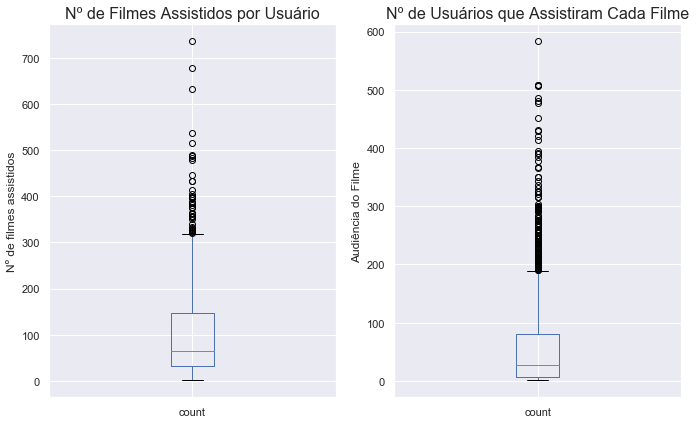

Descrição dos Filmes por Usuário


,count,mean,std,min,25%,50%,75%,max
count,944.0,105.608051,100.62503,1.0,33.0,64.0,147.25,736.0


In [4]:
#analise exploratoria
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
Users_Count_100k = rat_100k.groupby('User_Id').Rating.agg(['count'])
Users_Count_100k.boxplot()
plt.title("Nº de Filmes Assistidos por Usuário")
plt.ylabel("Nº de filmes assistidos")


plt.subplot(1,2,2)
Movies_Count_100k = rat_100k.groupby('Movie_Id').Rating.agg(['count'])
Movies_Count_100k.boxplot()
plt.title("Nº de Usuários que Assistiram Cada Filme")
plt.ylabel("Audiência do Filme")


plt.tight_layout()
plt.show()

print("Descrição dos Filmes por Usuário")
Users_Count_100k.describe().T

O __filme mais assistido__ com aproximadamente __600 visualizações__, porém a mdeiana de visualizações é de apenas 27 filmes, o que indica que teremos um vetor de notas extremamente esparço, o que favorece o uso de alguma tecnica de redução de dimensionalidade. 

In [5]:
print("Usuários Por Filme")
Movies_Count_100k.describe().T  

Usuários Por Filme


,count,mean,std,min,25%,50%,75%,max
count,1664.0,59.91226,80.679656,1.0,7.0,27.0,80.0,583.0


# Treinamento do Modelo

In [6]:
from sklearn.decomposition import KernelPCA
def plot_pca(data, dim_list = (3,3,3), plot = True):

    #dimensoes da figura
    sub_plot = range(131, 134)
    if plot==True: plt.figure(figsize=(15, 5))
    
    PcaComp = {}
    kernel_list = ("linear", "rbf", "sigmoid")
    for subplot, kernel, dim in zip(sub_plot, kernel_list, dim_list):

        #obtem as componentes do PCA
        Z_Comp = KernelPCA(n_components=dim,kernel=kernel,fit_inverse_transform=True).fit_transform(data)
        PcaComp[kernel] = Z_Comp
        
        
        
        #(%)Variancia explicada pelas componentes
        explained_var = np.var(Z_Comp, axis=0)
        explained_var_ratio = explained_var / np.sum(explained_var)
        explained_var_sum = np.cumsum(explained_var_ratio)*100

        if plot==True:
            #plotando as dimensoes 0 e 1 do PCA
            plt.subplot(subplot)
            plt.scatter(Z_Comp[:, 0], Z_Comp[:, 1])

            #labels do gráfico
            plt.title('Kernel {} | Dim:{} | Var: {:.1f}%'.format(kernel.capitalize(),dim, explained_var_sum[0]))
            plt.xlabel("$z_1$")
            if subplot == 131: plt.ylabel("$z_2$")


    plt.tight_layout
    plt.show()
    return PcaComp
ratings_100k,rat_sparse = fill_na(rat_100k, "item", "mean")
PCA_Comps = plot_pca(ratings_100k, dim_list = (3,2,3)) 

In [7]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances
from sklearn.metrics.pairwise import manhattan_distances

class Similarity_Matrix:
    
    def __init__(self, N_components, metric):
        self.N_components = int(N_components)
        self.metric = metric
        
    
    def similarity_(self, data, transformed_data):
        self.data = data
        self.transformed_data = transformed_data
        
        if self.metric == "manhattan":
            return pd.DataFrame(manhattan_distances(X=self.data, Y=self.transformed_data))
        
        if self.metric == "euclidean":
            return pd.DataFrame(euclidean_distances(X=self.data, Y=self.transformed_data))
        
        

    def landmarks_similarity(self, data, data_filled):
        self.data = data
        self.data_filled = data_filled
   
        
        #seleciona os N_landmarks usuários com mais filmes vistos
        UI_count = self.data.T.describe().T
        self.landmarks_id = UI_count['count'].sort_values(ascending=False).head(self.N_components)
        self.landmarks_id = pd.DataFrame(self.landmarks_id).index.tolist()
        
        #seleciona os as colunas dos landmarks preenchidos (dentro do k-fold de treinamento)
        self.UI_landmarks = self.data_filled.loc[self.landmarks_id]
        
        #retorna a matriz User/Item vs Landmark
        return self.similarity_(self.data_filled, self.UI_landmarks)
        
  
    
    def pca_similarity(self, data_filled):
        self.data_filled = data_filled

        UI_PCA = KernelPCA(n_components=self.N_components, 
                           kernel="linear", fit_inverse_transform=True).fit_transform(self.data_filled)
        
        #retorna a matriz User/Item vs PCA
        return pd.DataFrame(UI_PCA)
     
        
    #passo 2->3 para pegar a matrix Suu   
    def SM_Matrix(self, UI_components_matrix):  
        self.UI_components_matrix = UI_components_matrix
        return self.similarity_(self.UI_components_matrix, self.UI_components_matrix)
    
    
    #reduz a matrix de similaridade entre os K_viz selecionados (ALG 1??)
    def SM_redux(self, SM_Matrix, K_viz_list): #precisa da linha do proprio u??? 
        self.SM_Matrix = SM_Matrix
        self.K_viz_list = K_viz_list
        
        Redux_SM = SM_Matrix[K_viz_list, :]
        Redux_SM = Redux_SM[:, K_viz_list]
        
        return Redux_SM

In [8]:
##Plotar o pairplot da reducao com landmarks
X_filled, X_sparse = fill_na(rat_100k, "item", "mean")
SM = Similarity_Matrix(3, "euclidean")
SM_Euc_100k = SM.landmarks_similarity(X_sparse,X_filled)
#sns.pairplot( SM_Euc_100k, x_vars=SM_Euc_100k.columns, y_vars=SM_Euc_100k.columns)

In [9]:
def get_parameters(model, n_try):
    
    
    if model=="PCA":
        k_neighboors_list = np.sort(np.array(list(set(np.rint(np.logspace(1, 2.5, n_try)))))) #10..316
        components_list = np.sort(np.array(list(set(np.rint(np.logspace(1, 2.5, n_try)))))) #10..316
        similarity_metrics = ["euclidean", "manhattan"]
        fill_list = ["mean"]#, "zero",]
            
            
    if model=="Landmarks":        
        k_neighboors_list = np.sort(np.array(list(set(np.rint(np.logspace(1, 2.5, n_try)))))) #10..316
        components_list = np.sort(np.array(list(set(np.rint(np.logspace(1, 2.7, n_try)))))) #10..500
        similarity_metrics = ["euclidean", "manhattan"]
        fill_list = ["mean"]#, "zero",]


    knn_parameters = {
        "k_neighboors_list": k_neighboors_list,
        "components_list": components_list,
        "similarity_metrics": similarity_metrics,
        "fill_list": fill_list
    }
    
    return knn_parameters

In [218]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from math import sqrt
def predict_rating2(X_train, X_test, y_train, y_test, y_train_sparse, y_test_sparse, k_neighboors):
    K_viz_list = {}
    for user in y.index:
        #lista dos vizinhos (u') mais proximos de U
        K_viz_list[user] = X[user].sort_values(ascending=False).index[1: 1+k_neighboors]
    
    # Fazendo as previsões
    for i in range(y.columns):
        pred_ratings[i,:] = top_k_distances[i].T.dot( 
                                ratings_train[top_k_users][i])/np.array(
                                [np.abs(top_k_distances[i].T).sum(axis=0)]).T
        
        
        
        
    knn = KNeighborsRegressor(k_neighboors, weights="distance",metric="euclidean").fit(X_train, y_train)
    #knn = KNeighborsRegressor(k_neighboors).fit(X_train, y_train)
    
    viz = np.array(X_train.iloc[0,:]).reshape((1, -1))
    
    print(knn.kneighbors(viz)) 

    #print("X_train: ", X_train.shape)
    print("X_train: ", X_train)
    #print("X_test: ", X_test.shape)
    #print("y_train: ", y_train.shape)
    #print("y_test: ", y_test.shape)
    #print("#######")
    
    
    y_pred = knn.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = math.sqrt(mean_squared_error(y_test, y_pred))
    
    #print("y_train_sparse", y_train_sparse.shape)
    #print("y_test_sparse", y_train_sparse.shape)
    #print("y_pred", y_pred.shape)
    #print("#######")
    #print("y_pred: ", y_pred)
    #print("y_test: ", y_test)
    erro=br
    
    #limpar memoria
    knn, y_pred = None, None
    return mae_test, mse_test




#####################
#####################
#####################


def get_error(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    #pred = pred.flatten()
    #actual = actual.flatten()
    
    print(pred[:10])
    print(actual[:10])
    
    
    return mean_squared_error(pred, actual), math.sqrt(mean_squared_error(pred, actual))


   #predict_rating(SM_train, SM_test, y_train_filled, y_test_filled, y_train_sparse, y_test_sparse, kn)
def predict_rating(X_train, X_test, y_train, y_test, y_train_sparse, y_test_sparse, k_neighboors):
    
    #start1 = time.time()

    X = X_test
    y = y_test
    
    y_sparse = y_test_sparse
    X.columns = y.index
    X.index = y.index
    
    
    
    knn = KNeighborsRegressor(k_neighboors, weights="distance",metric="euclidean").fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(y_pred)
    #print(y_pred.shape)
    #print(y_sparse.shape)
    y_sparse[np.isnan(y_sparse)] = 0
    mae, mse = get_error(np.array(y_pred), np.array(y_sparse))
    
    print(mae)
    print(mse)
    
    return mae, mse
    
    ############################
    ############################
    #########################
    pred_ratings = np.zeros((len(y_train.index)+len(y_test.index) , len(y_train.columns)))
    #print(pred_ratings.shape)
    users_mean = y.mean(1)
    pred = {}
    for user in y.index:
        
        
        #lista dos vizinhos (u') mais proximos de U
        K_viz_list = X[user].sort_values(ascending=False).index[1: 1+k_neighboors]
        
        
        #elementos da SM que vao ser usados
        S_uu = X[user][K_viz_list]
        sum_S_uu = sum(S_uu)
        

        #media do usuario
        u_bar = users_mean[user]
        uk = np.array([users_mean.loc[K_viz_list],]*len(y.columns)).T
        yt = y.loc[K_viz_list]
        
        #preenche a nota
        pred_ratings[user][y.columns] = (np.dot(S_uu, (yt[y.columns] - uk))/sum_S_uu) + u_bar
        

    #elapsed_time1 = time.time() - start1
    #print("ep1: ", elapsed_time1)
    
    pred_ratings = pd.DataFrame(pred_ratings)
    pred_ratings = pred_ratings.iloc[y.index]
    y_sparse[np.isnan(y_sparse)] = 0
    
    #print(pred_ratings.shape)
    #print(y_test.shape)
    
    mae, mse = get_error(np.array(pred_ratings), np.array(y_sparse))
    
    print(mae)
    print(mse)
    pred_ratings = None
    return mae, mse

In [11]:
def agg_kfold(df):
    columns=["fold","fill_na","Sim_Metric","Components","k_neighboors","mae_test","mse_test","elapsed_time"]
    
    #Agregate mae
    aggdf=df.groupby(columns[1:5]).mae_test.agg(["mean"])
    mae_mean_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['mae_test']=mae_mean_fold
    
    #Agregate mse
    aggdf=df.groupby(columns[1:5]).mse_test.agg(["mean"])
    mse_mean_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['mse_test']=mse_mean_fold
    
    #Agregate time
    aggdf=df.groupby(columns[1:5]).elapsed_time.agg(["mean"])
    elapsed_time_fold = [i for i in aggdf['mean'][:]]
    df = df[df.fold == 1]
    df['elapsed_time']=elapsed_time_fold
    
    
    #atribute
    df = df.loc[:,["fill_na", "Sim_Metric","Components","k_neighboors", "mae_test", "mse_test", "elapsed_time"]]
    
    return df

In [211]:
#grid search
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
def grid_search(X, components, kind, n_try):
    parameters = get_parameters(components, n_try)

    result  = pd.DataFrame(
        columns=["fold", "fill_na", "Sim_Metric", "Components", "k_neighboors", "mae_test", "mse_test", "elapsed_time"])
    fold, row = 0,0
    y = X
    
    #K-Fold
    kf = KFold(n_splits=2, shuffle=True)
    X_filled, X_sparse = fill_na(X, kind, fill_type='zero') #to get split index
    

    # Item x Item (index: Movies, col: User)
    for train_index, test_index in kf.split(X_filled):
        fold += 1
        for fill_type in parameters['fill_list']:
            
            X_filled, X_sparse = fill_na(X, kind, fill_type)
            y_filled, y_sparse = fill_na(y, kind, fill_type)
            
            
            # get train and test splits
            X_train_sparse, X_test_sparse = X_sparse.iloc[train_index], X_sparse.iloc[test_index]
            y_train_sparse, y_test_sparse = y_sparse.iloc[train_index], y_sparse.iloc[test_index]
            
            X_train_filled, X_test_filled = X_filled.iloc[train_index], X_filled.iloc[test_index]
            y_train_filled, y_test_filled = y_filled.iloc[train_index], y_filled.iloc[test_index]


            for metric in parameters['similarity_metrics']:
                for N_components in parameters['components_list']:
                    
                    SM = Similarity_Matrix(N_components, metric)
                    
                    if components == "Landmarks":
                        UI_Comp_train = SM.landmarks_similarity(X_train_sparse, X_train_filled)
                        UI_Comp_test = SM.landmarks_similarity(X_test_sparse, X_test_filled)
                    
                    if components == "PCA":
                        UI_Comp_train  = SM.pca_similarity(X_train_filled)
                        UI_Comp_test = SM.pca_similarity(X_test_filled)

                    
                    SM_train, SM_test = SM.SM_Matrix(UI_Comp_train), SM.SM_Matrix(UI_Comp_test)
                    for kn in parameters['k_neighboors_list']:
                        start1 = time.time()

                        mae_test, mse_test = predict_rating(
                                                        SM_train, SM_test, 
                                                        y_train_filled, y_test_filled,
                                                        y_train_sparse, y_test_sparse, int(kn))
                        


                        elapsed_time = time.time() - start1
                        result.loc[row]=[fold,fill_type,metric,N_components,kn,mae_test,mse_test,elapsed_time]
                        row +=1
                    
                    #Limpar memoria
                    SM, UI_Comp_train, UI_Comp_test,SM_train, SM_test = None,None,None,None,None
                        
                        
    result = agg_kfold(result)
    return result

In [219]:
model_name = ["100k_item_Landmarks"
    ,"100k_item_PCA"
    ,"100K_user_Landmarks"
    ,"100k_user_PCA"
    ,"1M_item_Landmarks"
    ,"1M_item_PCA"
    ,"1M_user_Landmarks"
    ,"1M_user_PCA"]

def get_results(db_100k, db_1M, model_name, n_try):

    database_list = [db_100k]#, db_1M]
    kind_list = ["item","user"]
    kind_list = ["user"]
    components_list = ["Landmarks", "PCA"]
    results, ind_name = {},0
    
    for data in database_list:
 
        for kind in kind_list:
        
            for components in components_list:
                print(model_name[ind_name])
                
                results[model_name[ind_name]] = grid_search(data, components, kind, n_try)
                ind_name+=1
                #break
            #break
        #break
    
    return results        
n_try = 2 #lembrar de arrumar o kfold
results = get_results(rat_100k, rat_1M, model_name, n_try)
pd.DataFrame.from_dict(results[model_name[0]]).head()

100k_item_Landmarks
[[4.20354051 3.10523048 2.92708015 ... 3.         3.         3.        ]
 [3.97567829 3.28538029 3.03000187 ... 3.         3.         3.        ]
 [4.03742822 3.32307625 2.92665329 ... 3.         3.         3.        ]
 ...
 [3.97591201 3.18551618 3.12311803 ... 3.         3.         3.        ]
 [3.88789829 3.28540749 3.03000236 ... 3.         3.         3.        ]
 [4.15141815 3.18552441 2.81679265 ... 3.         3.         3.        ]]
[4.20354051 3.10523048 2.92708015 3.8296777  3.34252567 3.57692308
 4.33901235 4.19969731 4.04841627 3.98128316]
[5. 3. 4. 3. 3. 5. 4. 1. 5. 3.]
1.0174080558538232
1.008666474040762
[[3.91755063 3.20839967 3.01400768 ... 3.         3.         3.        ]
 [3.86623763 3.21672438 3.05346441 ... 3.         3.         3.        ]
 [3.88479471 3.20764611 3.03076518 ... 3.         3.         3.        ]
 ...
 [3.88429629 3.2150136  3.05295696 ... 3.         3.         3.        ]
 [3.86610549 3.21684025 3.05341389 ... 3.         3.     

KeyboardInterrupt: 

In [ ]:
name = 0  ##entre 0 e 7
print(model_name[name])
pd.DataFrame.from_dict(results[model_name[name]]).head()

In [ ]:
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
#gerar gráfico MAE/MSE vs Landmarks com K-Viz fixo
plt.rcParams['figure.figsize'] = 16, 6
plt.rcParams['axes.labelsize'] = 16
#colors_list = ["blue","green","red","cyan","magenta","yellow","black","white"]
colors_list = ['b-','g-','r-','c-','m-','y-','k-','w-']
ind=-1

for m in range(8):
    #print(model_name[m])
    
    df = pd.DataFrame.from_dict(results[model_name[m]])
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            kn = parameters['k_neighboors_list']
            k_viz = kn[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.k_neighboors ==k_viz)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.k_neighboors ==k_viz)].elapsed_time
            components = parameters["components_list"]
            ind+=1

            plt.subplot(1,3,1)
            plt.title('MAE - k-vizinhos: '+ str(k_viz))
            plt.ylabel('MAE')
            plt.xlabel('Nº de Landmarks')
            label = model_name[m]+' '+ metric
            plt.plot(components,mae, colors_list[ind], label=label)
            #plt.legend()


            plt.subplot(1,3,2)
            plt.title('RMSE - k-vizinhos: '+ str(k_viz))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de Landmarks')
            plt.plot(components,mse, colors_list[ind], label=label)
            plt.legend()
            

            plt.subplot(1,3,3)
            plt.title('Tempo - k-vizinhos: '+ str(k_viz))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Landmarks')
            plt.plot(components,te, colors_list[ind], label=label)
            #plt.legend()
            #break
        #break
        
plt.tight_layout()
plt.show()

In [ ]:
#gerar gráfico MAE/MSE vs Kviz com land fixo
ind=-1
for m in range(8):
    #print(model_name[m])
    
    df = pd.DataFrame.from_dict(results[model_name[m]])
    parameters = get_parameters("Landmarks", n_try) #nao generico
    for metric in parameters['similarity_metrics']:
        for fill_type in parameters['fill_list']:
            comp = parameters['components_list']
            cp=comp[1]

            mae = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mae_test
            mse = df.loc[(df.fill_na == fill_type)&(df.Sim_Metric == metric)&(df.Components == cp)].mse_test
            te=df.loc[(df.fill_na == fill_type)&(df.Sim_Metric==metric)&(df.Components ==cp)].elapsed_time
            k_vizinhos = parameters['k_neighboors_list']
            ind+=1
 
            plt.subplot(1,3,1)
            plt.title('MAE - Landmarks: '+ str(cp))
            plt.ylabel('MAE')
            plt.xlabel('Nº de vizinhos (k)')
            label = model_name[m]+' '+ metric
            plt.plot(k_vizinhos, mae, colors_list[ind])#, label=label)
            #plt.legend()

            
            plt.subplot(1,3,2)
            plt.title('RMSE - Landmarks: '+ str(cp))
            plt.ylabel('RMSE')
            plt.xlabel('Nº de vizinhos (k)')
            plt.plot(k_vizinhos, mse, colors_list[ind], label=label)
            plt.legend()
            
            
            plt.subplot(1,3,3)
            plt.title('Tempo - Landmarks: '+ str(cp))
            plt.ylabel('Tempo')
            plt.xlabel('Nº de Vizinhos (k)')
            plt.plot(k_vizinhos,te, colors_list[ind], label=label)
            #plt.legend()
        
plt.tight_layout()
plt.show()

In [191]:
n_try

2

In [131]:
c = np.ones((10,1664))
b = np.ones((10,1)).T

a = np.matmul(b,c)

aa = np.matmul(a.T,b).T

In [126]:
aa.shape

(10, 1664)

In [132]:
b.shape

(1, 10)

# Lixo

In [ ]:
df = pd.DataFrame.from_dict(results[model_name[0]])
columns=["fold", "fill_na", "Sim_Metric", "Components", "k_neighboors", "mae_test", "mse_test", "elapsed_time"]

#Agregate mae
df.groupby(columns[1:5]).mae_test.agg(["mean"])

In [ ]:
n=0
toy1 = np.array([[2,n,n,5,1,n],[n,n,3,4,3,1],[3,1,3,n,5,n],[n,4,n,n,5,3],[n,1,2,3,n,n],[1,n,2,n,2,n]])

toy3 = np.array([[1.0, .88, .48, .97, .90, .99],[.88,1.0,0,.73,.58,.94],[.48, 0, 1.0, .69, .82, .35],[.97, .73, .69, 1.0, .98, .92],[.9, .58, .82, .98, 1.0, .83],[.99, .94, .35, .92, .83, 1.0]])

In [ ]:
np.dot([1,1],(toy3[0:2,2]-[1,2]))

In [137]:
X = np.array([i for i in range(4)]).reshape((-1, 1)).T
#X = X.reshape((-1, 1)).T

X.shape

(1, 4)

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
c=np.array([[3,3,5],[1,2,2]])
euclidean_distances(c)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from math import sqrt
import mglearn

def predict_r(X_train, X_test, y_train, y_test, k_neighboors):
    
    #knn=KNeighborsRegressor(k_neighboors, weights="distance", metric="cosine")
    knn=KNeighborsRegressor(k_neighboors,  weights="distance", metric="euclidean")
    
    
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = math.sqrt(mean_squared_error(y_test, y_pred))

    
    top_k_distances, top_k_users = knn.kneighbors(X_train, return_distance = True)
    print("#######")
    print(top_k_distances)
    print("----")
    print(top_k_users) 
    #print("X_train: ", X_train.shape)
    #print("X_test: ", X_test.shape)
    #print("y_train: ", y_train.shape)
    #print("y_test: ", y_test.shape)
    #print("y_pred", y_pred.shape)
    #print("y_pred", y_pred)
    #print("y_test: ", y_test)
    
    print("#######")

    return mae_test, mse_test

In [ ]:
#Toy
from sklearn.model_selection import train_test_split

n= None
toy1 = np.array([[2,n,n,5,1,n],[n,n,3,4,3,1],[3,1,3,n,5,n],[n,4,n,n,5,3],[n,1,2,3,n,n],[1,n,2,n,2,n]])

toy3 = np.array([[1.0, .88, .48, .97, .90, .99],[.88,1.0,0,.73,.58,.94],[.48, 0, 1.0, .69, .82, .35],[.97, .73, .69, 1.0, .98, .92],[.9, .58, .82, .98, 1.0, .83],[.99, .94, .35, .92, .83, 1.0]])

m = [2,2,2.5,4,16/5, 2]
toy2 = np.array([[2,m[1],m[2],5,1,m[5]],[m[0],m[1],3,4,3,1],[3,1,3,m[3],5,m[5]],[m[0],4,m[2],m[3],5,3],[m[0],1,2,3,m[4],m[5]],[1,m[1],2,m[3],2,m[5]]])




X = np.linspace(1,10,10)
y = np.array([i**2 for i in X])

X_train = np.array(X[::2]).reshape((-1, 1))
X_test = np.array(X[1::2]).reshape((-1, 1))

X1 = np.array(X[::2])
X2 = np.array(X[1::2])


y_train = np.array([i**2 for i in X1])#.reshape((-1, 1))
y_test = np.array([i**2 for i in X2])#.reshape((-1, 1))


X, y = mglearn.datasets.make_wave(n_samples=40)



X = np.linspace(1,10,10)
y = np.array([i**2 for i in X])
X = X.reshape((-1, 1))


X=toy3
y=toy2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

print("X_train: ", X_train)
print("X_test: ", X_test)
#print("y_train: ", y_train)
#print("y_test: ", y_test)




for k_neighboors in range(1,5):
    mae, mse = predict_r(X_train, X_test, y_train, y_test, k_neighboors)
    print(mae, mse)

In [ ]:
#X = [[0], [1], [2], [3]]
#y = [0, 0, 1, 1]


X = np.array([i for i in range(4)])
X = X.reshape((-1, 1))
y = np.array([i**3 for i in X])


from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2).fit(X, y) 


print(neigh.predict([[5]]))

In [ ]:

   #predict_rating(SM_train, SM_test, y_train_filled, y_test_filled, y_train_sparse, y_test_sparse, kn)
def predict_rating(X_train, X_test, y_train, y_test, y_train_sparse, y_test_sparse, k_neighboors):
    
    X = X_test
    y = y_test
    #return np.random.randint(1,10)/2,np.random.randint(1,10)/2
    
    pred_ratings = np.zeros((len(y.index), len(y.columns)))
    users = X.index
    itens = y.columns
    users_mean = y.mean(1)

    for user in users:
        
        
    #lista dos vizinhos (u') mais proximos de U
    K_viz_list = X[user].sort_values(ascending=False).index[1: 1+k_neighboors]

    #media do usuario
    u_bar = users_mean[user]

    #elementos da SM que vao ser usados
    S_uu = X[user][K_viz_list]
    
    for item in itens:

        # r_u'v - u'.mean()
        r_uv = [y[k][item] - users_mean[k] for k in K_viz_list]

            #nota predita
            pred_ratings[user][item]  = (np.dot(S_uu,  r_uv)/sum(S_uu)) + u_bar


            y_pred[user][item] = pred_rating_uv

    
    
    
    print(y_pred)
    erro=br
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = math.sqrt(mean_squared_error(y_test, y_pred))


    return knn, mae_test, mse_test


In [ ]:
toy3[1::,1::]

In [ ]:
rpf, rps = fill_na(rat_100k, "user", "mean")
rpf.head()

In [190]:
f = rpf
f.iloc[[0,1,2]]

NameError: name 'rpf' is not defined

In [ ]:
10**2.7

In [ ]:
10**2.7

In [ ]:
rpf